# Exoplanet Hunting with a Convolutional Neural Network (CNN) Classifier

This is the second part of a two-part workshop focused on classifying exoplanet candidates observed by the Kepler space telescope.


<p float="left">
  <img src="https://upload.wikimedia.org/wikipedia/commons/4/45/Kepler_Space_Telescope_spacecraft_model_2.png" width="200" />
  <img src="https://exoplanets.nasa.gov/system/resources/detail_files/280_656348main_ToV_transit_diag.jpg" width="500" /> 
</p>

## Recap
Before we dive in lets do a recap. In case you need the data, it is located [here](https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data/). Download and unzip the training and test data sets into the `./data/` folder.

We will start out with loading and normalizing the data, then I will show you the batch generator function needed to ballance the data set, and then we will dive into the CNN to classify if a star observed by Kepler contains a exoplanet. In case you need to read up on what CNN is and how it works, check out the [CNN wiki](https://en.wikipedia.org/wiki/Convolutional_neural_network) and a [Medium](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) article that distills the jergon into something a 5 year old can understand.

In [1]:
import tensorflow
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
print(f'Pandas version {pd.__version__}')
print(f'Tensorflow version {tensorflow.__version__}')
print(f'Scikit Learn version {sklearn.__version__}')

Pandas version 1.0.3
Tensorflow version 2.1.0
Scikit Learn version 0.21.3


## Load and Normalize data

In [4]:
def load_data(path):
    data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(data.columns):
        if 'FLUX' in column:
            data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    data.LABEL -= 1
    return data

def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm


train_data = load_data('./exoTrain.csv')
train_data = normalize_data(train_data)

test_data = load_data('./exoTest.csv')
test_data = normalize_data(test_data)

## Visualize the light curves

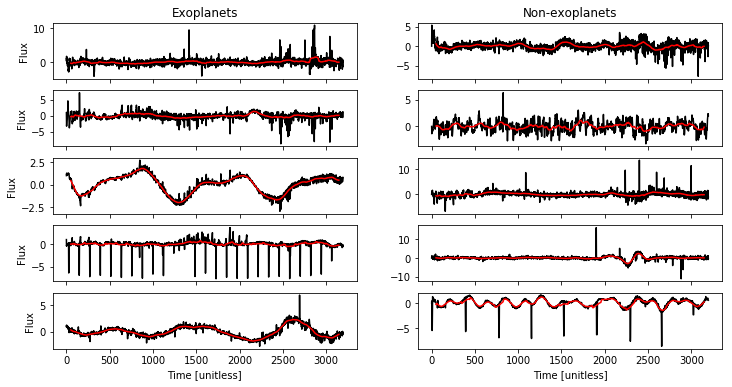

In [5]:
n_plots = 5
n_smooth = 100 # Number of data points to smooth (boxcar average) over

exo_df = train_data[train_data.LABEL == 1].sample(n=n_plots, random_state=123)
nonexo_df = train_data[train_data.LABEL == 0].sample(n=n_plots, random_state=123)

exo_df_rolling = exo_df.rolling(n_smooth, axis=1, center=True).mean()
nonexo_df_rolling = nonexo_df.rolling(n_smooth, axis=1, center=True).mean()

_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    a.plot(exo_df.iloc[i, :].values, 'k')
    a.plot(exo_df_rolling.values[i, :], 'r')
    a.set_ylabel('Flux')
for i, a in enumerate(ax[:, 1]): 
    a.plot(nonexo_df.iloc[i, :].values, 'k')
    a.plot(nonexo_df_rolling.values[i, :], 'r')
ax[0,0].set(title='Exoplanets')
ax[0,1].set(title='Non-exoplanets')
ax[-1,0].set_xlabel('Time [unitless]')
ax[-1,1].set_xlabel('Time [unitless]');

## Reshape the data for CNN
Now extract numpy arrays from Pandas and reshape the arrays to input into the CNN.

In [6]:
train_data_array = train_data.iloc[:, 1:].values
train_data_labels = train_data.iloc[:, 0].values

test_data_array = test_data.iloc[:, 1:].values
test_data_labels = test_data.iloc[:, 0].values

train_data_array = train_data_array.reshape(*train_data_array.shape, 1)
train_data_labels = train_data_labels.reshape(train_data_labels.shape[0], 1)
test_data_array = test_data_array.reshape(*test_data_array.shape, 1)
test_data_labels = test_data_labels.reshape(test_data_labels.shape[0], 1)

print(train_data_array.shape, train_data_labels.shape)
print(test_data_array.shape, test_data_labels.shape)

(5087, 3197, 1) (5087, 1)
(570, 3197, 1) (570, 1)


## Light Curve Batch Generator
To ballance the data set we create a batch function to return equal number of exoplanet and non-exoplanet light curves. There will be duplicate light curves.

We will also shift the light curves by a random amount to augmentat the data.

In [7]:
def light_curve_batch_generator(x, y, batch_size=32, augmentation='shift'):
    """
    Returns batch_size number of random exoplanets and non-exoplanet detections.
    """
    idx_exo = np.where(y==1)[0]
    idx_nonexo = np.where(y==0)[0]
 
    while True:
        # Randomly pick half exoplanets and half non-exoplanets
        random_idx_exo = np.random.choice(idx_exo, size=batch_size//2, replace=True)
        random_idx_nonexo = np.random.choice(idx_nonexo, size=batch_size//2, replace=True)
        random_idx = np.concatenate((random_idx_exo, random_idx_nonexo))
        np.random.shuffle(random_idx)
        train_data = x[random_idx, :, :]
        train_labels = y[random_idx, :]

        if augmentation == 'shift':
            # Shift each lightcurve by a random index. This is one augmentation technique 
            # to increase the number of observations but will have discontinuities. This 
            # helps the CNN learn better.
            for i in range(batch_size):
                random_shift = np.random.randint(train_data.shape[1])
                train_data[i] = np.roll(train_data[i], random_shift, axis=0)
        elif augmentation == 'noise':
            # Another augmentation technique to add Gaussian noise to each light curve.
            # Does not work as well as the shift augmentation. Can you think of another 
            # method? 
            train_data = np.random.normal(loc=train_data, scale=0.5)
        yield train_data, train_labels

Test the batch generator

In [8]:
batch_gen = light_curve_batch_generator(train_data_array, train_data_labels)

for _ in range(3):
    print(next(batch_gen))

(array([[[ 0.49930207],
        [-0.20665488],
        [-0.18911424],
        ...,
        [ 0.52355581],
        [ 0.09803267],
        [ 0.3349397 ]],

       [[-1.69095097],
        [-0.58361382],
        [ 0.46524469],
        ...,
        [-0.47231928],
        [-0.47569514],
        [ 1.00222453]],

       [[-0.44928524],
        [-0.49177744],
        [-0.436121  ],
        ...,
        [-5.08776633],
        [-5.25073639],
        [-3.13245892]],

       ...,

       [[ 0.52817865],
        [ 0.56196582],
        [ 0.71520544],
        ...,
        [ 0.49813771],
        [ 0.3534575 ],
        [ 0.65519469]],

       [[-0.48243004],
        [-0.05759395],
        [-0.50954299],
        ...,
        [ 0.14575321],
        [-0.36779806],
        [ 0.26736279]],

       [[-0.22427031],
        [-0.78937796],
        [-0.64548853],
        ...,
        [-0.82957054],
        [-0.3456519 ],
        [-0.50481451]]]), array([[0],
       [1],
       [1],
       [1],
       [1],
       

## Define the CNN architecture

In [9]:
def cnn_model(norm='False'):
    """ 
    Describe the CNN model architecture here and compile it.
    """
    model = tensorflow.keras.models.Sequential()

    ### LAYER ###
    # Note that the input_shape = (Number of time steps, 1) so is only
    # one light curve.
    # The 8 filters are the building blocks to identify complex patterns.
    model.add(Conv1D(filters=8, kernel_size=25, activation='relu', 
                    input_shape=train_data_array.shape[1:]))
    model.add(MaxPooling1D(strides=4)) # strides downsamples the feature maps by strides.
    if norm:
        model.add(BatchNormalization()) # Normalize to mean=0 and std=1

    ### LAYER ###
    model.add(Conv1D(filters=16, kernel_size=25, activation='relu'))
    model.add(MaxPooling1D(strides=4))
    if norm:
        model.add(BatchNormalization()) # Normalize to mean=0 and std=1

    ### LAYER ###
    # model.add(Conv1D(filters=32, kernel_size=25, activation='relu'))
    # model.add(MaxPooling1D(strides=4))
    # if norm:
    #     model.add(BatchNormalization()) # Normalize to mean=0 and std=1

    ### LAYER ###
    # model.add(Conv1D(filters=64, kernel_size=25, activation='relu'))
    # model.add(MaxPooling1D(strides=4))
    
    # Flattens the array of n_filters number of 1D feature maps from the convolution.
    model.add(Flatten()) 

    # Dropout determines the fraction of the input units to drop. This reduces overfitting 
    # https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout
    # model.add(Dropout(0.5)) 

    ### NORMAL NEURAL NETWORK ###
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile and optimize the model
    model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
norm = False
model = cnn_model(norm=norm)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3173, 8)           208       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 793, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 769, 16)           3216      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 192, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                196672    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

## Now train the CNN model
This will take a while.

In [11]:
hist = model.fit(x=light_curve_batch_generator(train_data_array, train_data_labels), 
                validation_data=(test_data_array, test_data_labels), 
                verbose=2, epochs=60, steps_per_epoch=train_data_array.shape[0]//32)

  ...
    to  
  ['...']
Train for 158 steps, validate on 570 samples
Epoch 1/60
158/158 - 19s - loss: 0.6806 - accuracy: 0.5576 - val_loss: 0.5727 - val_accuracy: 0.8684
Epoch 2/60
158/158 - 13s - loss: 0.6362 - accuracy: 0.6444 - val_loss: 0.5078 - val_accuracy: 0.8456
Epoch 3/60
158/158 - 13s - loss: 0.5942 - accuracy: 0.6808 - val_loss: 0.5416 - val_accuracy: 0.7754
Epoch 4/60
158/158 - 13s - loss: 0.5512 - accuracy: 0.7191 - val_loss: 0.4223 - val_accuracy: 0.8386
Epoch 5/60
158/158 - 15s - loss: 0.5133 - accuracy: 0.7540 - val_loss: 0.4421 - val_accuracy: 0.8246
Epoch 6/60
158/158 - 14s - loss: 0.4935 - accuracy: 0.7692 - val_loss: 0.4097 - val_accuracy: 0.8456
Epoch 7/60
158/158 - 14s - loss: 0.4499 - accuracy: 0.8038 - val_loss: 0.4377 - val_accuracy: 0.8281
Epoch 8/60
158/158 - 13s - loss: 0.4208 - accuracy: 0.8190 - val_loss: 0.3260 - val_accuracy: 0.8860
Epoch 9/60
158/158 - 14s - loss: 0.3908 - accuracy: 0.8360 - val_loss: 0.3763 - val_accuracy: 0.8526
Epoch 10/60
158/158 -

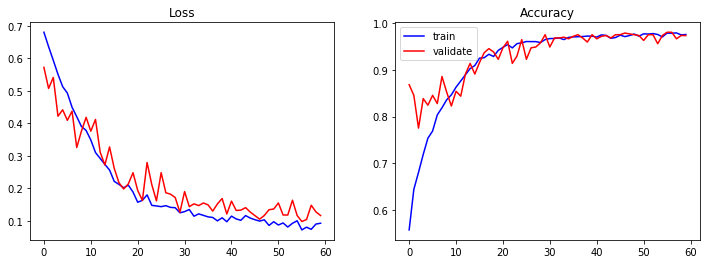

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist.history['loss'], color='b')
ax[0].plot(hist.history['val_loss'], color='r')
ax[1].plot(hist.history['accuracy'], color='b', label='train')
ax[1].plot(hist.history['val_accuracy'], color='r', label='validate')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[1].legend();

# if norm:
#     plt.savefig('cnn_with_batch_normalization.png')
# else:
#     plt.savefig('cnn_without_batch_normalization.png')

What is the model's final loss and accuracy?

In [13]:
model.evaluate(test_data_array, test_data_labels, verbose=1)

570/570 [==============================] - 1s 883us/sample - loss: 0.1168 - accuracy: 0.9737


[0.11680616920715885, 0.9736842]

## CNN probability of exoplanets 
What probability of exoplanet does this CNN predict for exoplanets and nonexoplenets test light curves?

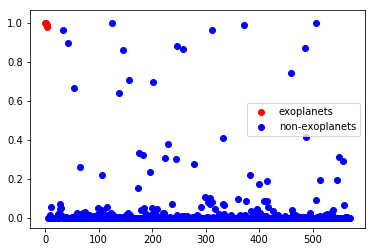

In [14]:
exo_idx = np.where(test_data_labels == 1)[0]
nonexo_idx = np.where(test_data_labels == 0)[0]
cnn_predict = model.predict(test_data_array)

plt.scatter(exo_idx, cnn_predict[exo_idx].flatten(), c='r', label='exoplanets')
plt.scatter(nonexo_idx, cnn_predict[nonexo_idx].flatten(), c='b', label='non-exoplanets')
plt.legend();

Exoplanets are assigned a high probability, > 0.8, while most non-exoplanet light curves are assigned a probability near 0. So far so good! So if we were to hand this trained CNN to the Kepler scientists, what probability threshold should we tell them to use? 

To quanity this question we will use the Receiver operating characteristic (ROC) curve to quantify the "optimal" tradeoff between false-positives and true-positive classifications.

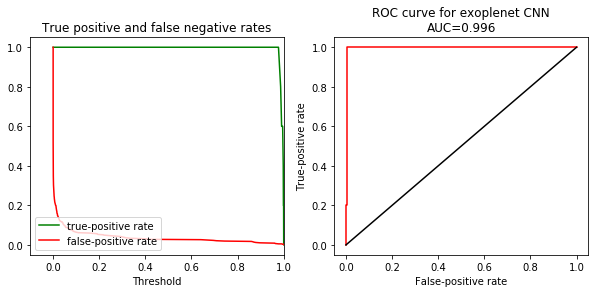

In [15]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_data_labels, cnn_predict, drop_intermediate=False)
auc = sklearn.metrics.auc(fpr, tpr)

_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(thresholds, tpr, 'g', label='true-positive rate')
ax[0].plot(thresholds, fpr, 'r', label='false-positive rate')
ax[0].set(xlabel='Threshold', xlim=(-0.1, 1), title='True positive and false negative rates')
ax[0].legend(loc=3)
ax[1].plot(fpr, tpr, 'r')
ax[1].plot(np.linspace(0, 1), np.linspace(0, 1), 'k')
ax[1].set(title=f'ROC curve for exoplenet CNN\nAUC={round(auc, 3)}', 
            xlabel='False-positive rate', ylabel='True-positive rate');

The point at (0, 1) on the ROC curve plot represent a perfect model since there it as 100% true-positive rate and 0% false-positive rate. This model is good, but not perfect. The optimal threshold is the threshold where the ROC curve is closest to (0, 1). Lets calculate that.

In [16]:
arr = np.array([tpr, fpr]).T
roc_curve = np.array(sorted(arr, key=lambda x: x[1]))

In [17]:
optimal_point_arr = np.array([np.zeros(len(roc_curve)), np.ones(len(roc_curve))]).T
roc_cure_array = np.array([fpr, roc_curve[:,0]]).T
d = np.linalg.norm(optimal_point_arr - roc_cure_array, axis=1)
optimal_threshold = thresholds[np.nanargmin(d)]
print(f'The optimal classification threshold for this CNN is {optimal_threshold}')

The optimal classification threshold for this CNN is 0.9773039221763611


In [18]:
cnn_predict[exo_idx].flatten() > optimal_threshold

array([ True,  True,  True,  True, False])

In [19]:
cnn_predict[nonexo_idx[:100]].flatten() > optimal_threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# TASKS
- Try other augmentation methods.
- Find how to save and load the CNN weights and architecture to a file to send to your collegues.
- Play around with the number of filters and kernel_size.

In [20]:
model.save('exoplanet.h5')

In [ ]:
load_model('exoplanet.h5')